In [1]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from Cooking import checkAndCreateDir
from helpers import predictImage

from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D, Conv2DTranspose, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [5]:
# Load training images
train_images = pickle.load(open("images/scene/out_reshaped_scenes.p", "rb" ))

# Load image labels
labels = pickle.load(open("images/labelled/out_1d_labels.p", "rb" ))

# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

In [6]:
# Normalize labels
labels = labels / 255

# Shuffle images along with their labels and split into training/validation sets
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

# Set optimization parameters
batch_size = 128
epochs = 1000
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [7]:
# Neural Network
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Upsample 1
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 2
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

In [8]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

MODEL_OUTPUT_DIR = 'model/lanes'

plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback]

In [9]:
# Compiling and training the model
model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks)

# Freeze layers since training is done
model.trainable = False
model.compile(optimizer='Adam', loss='mean_squared_error')


# Save model architecture and weights
model.save('model/lanes/trained_lane_model_3_layer_test.h5')

# Show summary of model
model.summary()

Epoch 1/1000
6/5 [================================] - 21s 4s/step - loss: 0.0062 - val_loss: 0.0056
Epoch 2/1000
6/5 [================================] - 18s 3s/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/1000
6/5 [================================] - 18s 3s/step - loss: 0.0029 - val_loss: 0.0032
Epoch 4/1000
6/5 [================================] - 17s 3s/step - loss: 0.0025 - val_loss: 0.0031
Epoch 5/1000
6/5 [================================] - 17s 3s/step - loss: 0.0022 - val_loss: 0.0029
Epoch 6/1000
6/5 [================================] - 17s 3s/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/1000
6/5 [================================] - 17s 3s/step - loss: 0.0019 - val_loss: 0.0023
Epoch 8/1000
6/5 [================================] - 17s 3s/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/1000
6/5 [================================] - 17s 3s/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/1000
6/5 [================================] - 17s 3s/step - loss: 0.0016 - val_loss: 0.0019

Epoch 35/1000
6/5 [================================] - 17s 3s/step - loss: 9.9919e-04 - val_loss: 9.2766e-04
Epoch 36/1000
6/5 [================================] - 17s 3s/step - loss: 9.8812e-04 - val_loss: 8.9406e-04
Epoch 37/1000
6/5 [================================] - 18s 3s/step - loss: 9.8495e-04 - val_loss: 9.2886e-04
Epoch 38/1000
6/5 [================================] - 17s 3s/step - loss: 9.8286e-04 - val_loss: 8.6369e-04
Epoch 39/1000
6/5 [================================] - 17s 3s/step - loss: 9.9243e-04 - val_loss: 9.1855e-04
Epoch 40/1000
6/5 [================================] - 17s 3s/step - loss: 9.8872e-04 - val_loss: 8.9792e-04
Epoch 41/1000
6/5 [================================] - 17s 3s/step - loss: 9.7685e-04 - val_loss: 8.6886e-04
Epoch 42/1000
6/5 [================================] - 17s 3s/step - loss: 9.7065e-04 - val_loss: 8.9205e-04
Epoch 43/1000
6/5 [================================] - 17s 3s/step - loss: 9.6596e-04 - val_loss: 8.6551e-04
Epoch 44/1000
6/5 [

Epoch 71/1000
6/5 [================================] - 19s 3s/step - loss: 9.0660e-04 - val_loss: 7.5573e-04
Epoch 72/1000
6/5 [================================] - 19s 3s/step - loss: 9.0522e-04 - val_loss: 7.8980e-04
Epoch 73/1000
6/5 [================================] - 19s 3s/step - loss: 9.4051e-04 - val_loss: 7.6454e-04
Epoch 74/1000
6/5 [================================] - 19s 3s/step - loss: 8.9356e-04 - val_loss: 7.9677e-04
Epoch 75/1000
6/5 [================================] - 20s 3s/step - loss: 9.1483e-04 - val_loss: 8.0597e-04
Epoch 76/1000
6/5 [================================] - 19s 3s/step - loss: 9.0033e-04 - val_loss: 8.0472e-04
Epoch 77/1000
6/5 [================================] - 20s 3s/step - loss: 8.9348e-04 - val_loss: 7.4920e-04
Epoch 78/1000
6/5 [================================] - 20s 3s/step - loss: 9.0868e-04 - val_loss: 7.9546e-04
Epoch 79/1000
6/5 [================================] - 19s 3s/step - loss: 8.8286e-04 - val_loss: 7.5803e-04
Epoch 80/1000
6/5 [

6/5 [================================] - 20s 3s/step - loss: 8.8310e-04 - val_loss: 7.5917e-04
Epoch 108/1000
6/5 [================================] - 20s 3s/step - loss: 8.5545e-04 - val_loss: 7.2594e-04
Epoch 109/1000
6/5 [================================] - 19s 3s/step - loss: 8.6436e-04 - val_loss: 7.3713e-04
Epoch 110/1000
6/5 [================================] - 19s 3s/step - loss: 8.6637e-04 - val_loss: 7.1202e-04
Epoch 111/1000
6/5 [================================] - 19s 3s/step - loss: 8.6532e-04 - val_loss: 7.5124e-04
Epoch 112/1000
6/5 [================================] - 17s 3s/step - loss: 8.5556e-04 - val_loss: 7.1921e-04
Epoch 113/1000
6/5 [================================] - 17s 3s/step - loss: 8.4938e-04 - val_loss: 7.1663e-04
Epoch 114/1000
6/5 [================================] - 17s 3s/step - loss: 8.6258e-04 - val_loss: 7.1574e-04
Epoch 115/1000
6/5 [================================] - 17s 3s/step - loss: 8.3720e-04 - val_loss: 7.1466e-04
Epoch 116/1000
6/5 [=====

Epoch 143/1000
6/5 [================================] - 17s 3s/step - loss: 8.0379e-04 - val_loss: 7.4273e-04
Epoch 144/1000
6/5 [================================] - 17s 3s/step - loss: 8.1253e-04 - val_loss: 6.8461e-04
Epoch 145/1000
6/5 [================================] - 16s 3s/step - loss: 7.9641e-04 - val_loss: 7.1650e-04
Epoch 146/1000
6/5 [================================] - 17s 3s/step - loss: 8.2487e-04 - val_loss: 6.8574e-04
Epoch 147/1000
6/5 [================================] - 16s 3s/step - loss: 8.2295e-04 - val_loss: 7.8450e-04
Epoch 148/1000
6/5 [================================] - 16s 3s/step - loss: 8.2792e-04 - val_loss: 6.8445e-04
Epoch 149/1000
6/5 [================================] - 16s 3s/step - loss: 8.0516e-04 - val_loss: 7.6590e-04
Epoch 150/1000
6/5 [================================] - 17s 3s/step - loss: 8.0276e-04 - val_loss: 6.7355e-04
Epoch 151/1000
6/5 [================================] - 16s 3s/step - loss: 8.0992e-04 - val_loss: 7.0126e-04
Epoch 152/

6/5 [================================] - 16s 3s/step - loss: 7.9740e-04 - val_loss: 6.6174e-04
Epoch 180/1000
6/5 [================================] - 16s 3s/step - loss: 7.9353e-04 - val_loss: 7.0933e-04
Epoch 181/1000
6/5 [================================] - 16s 3s/step - loss: 7.9922e-04 - val_loss: 6.7072e-04
Epoch 182/1000
6/5 [================================] - 16s 3s/step - loss: 7.6247e-04 - val_loss: 6.7725e-04
Epoch 183/1000
6/5 [================================] - 16s 3s/step - loss: 7.4987e-04 - val_loss: 6.6063e-04
Epoch 00183: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 80, 160, 3)        12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 158, 8)        224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 1

In [10]:
from keras.models import load_model

model = load_model('model/lanes/trained_lane_model_3_layer_test.h5')


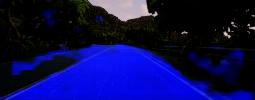

In [11]:
res = predictImage(model, "images/test/out_scene_965.jpg")
    
res

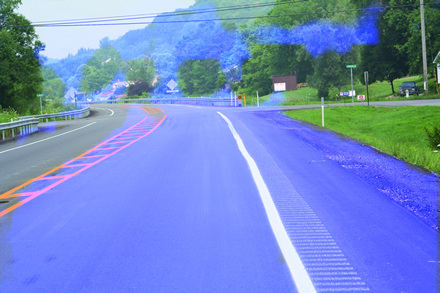

In [12]:
#res = predictImage(model, "images/two-lane-road.jpg", shape=(452, 602, 3))
#res = predictImage(model, "images/two-lane-road-2.jpg", shape=(229, 400, 3))
res = predictImage(model, "images/two-lane-road-3.jpg", shape=(293, 440, 3))
    
res

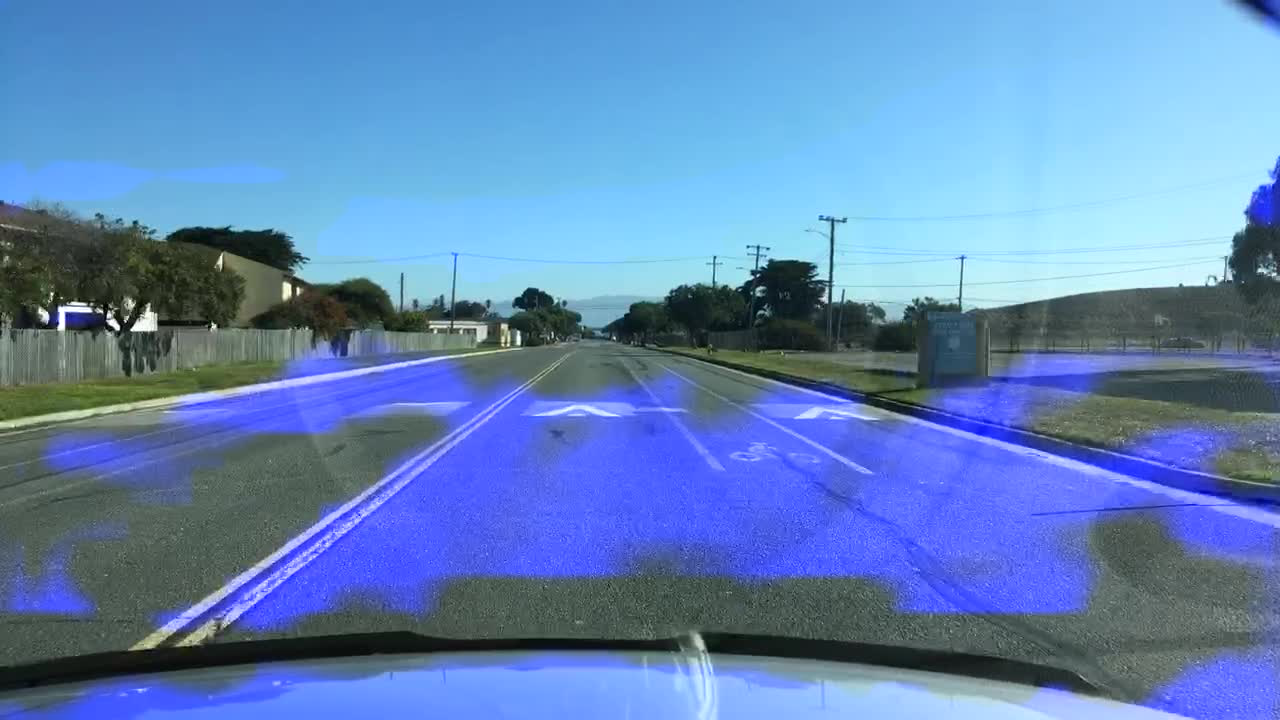

In [4]:
# test on a BDD image
res = predictImage(model, "images/d5cc7c4f-d5db11c6.jpg", shape=(720, 1280))

res